In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# Resampling
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler

# visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import RFECV


# session
import pickle

In [2]:
# helper functions
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = RandomForestClassifier( n_estimators = 10, n_jobs = -1 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    
def plot_RFECV( X , y ):
    # Create the RFE object and compute a cross-validated score.
    svc = SVC(kernel="linear", n_jobs = -1)
    # The "accuracy" scoring is proportional to the number of correct
    # classifications
    rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(3),
                  scoring='accuracy')
    rfecv.fit(X, y)

    print("Optimal number of features : %d" % rfecv.n_features_)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()

In [3]:
# load data
train = pd.read_csv('./train.csv', low_memory=False)
test = pd.read_csv('./test.csv', low_memory=False)

In [4]:
# analysis
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Olsson, Mr. Nils Johan Goransson",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


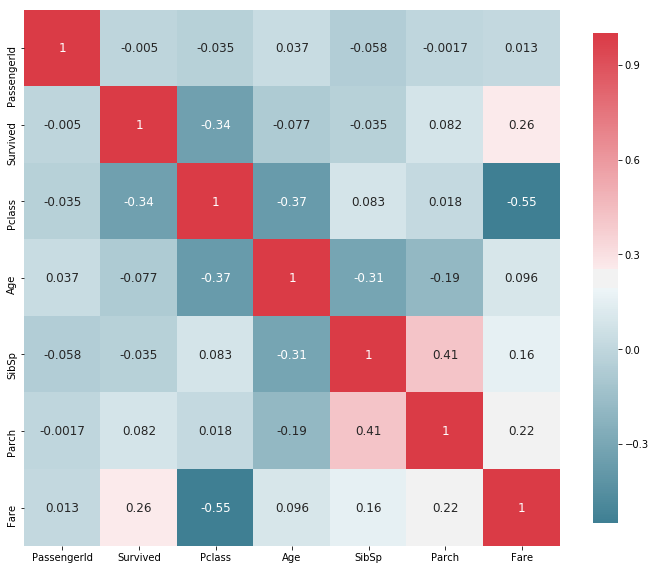

In [8]:
plot_correlation_map( train )

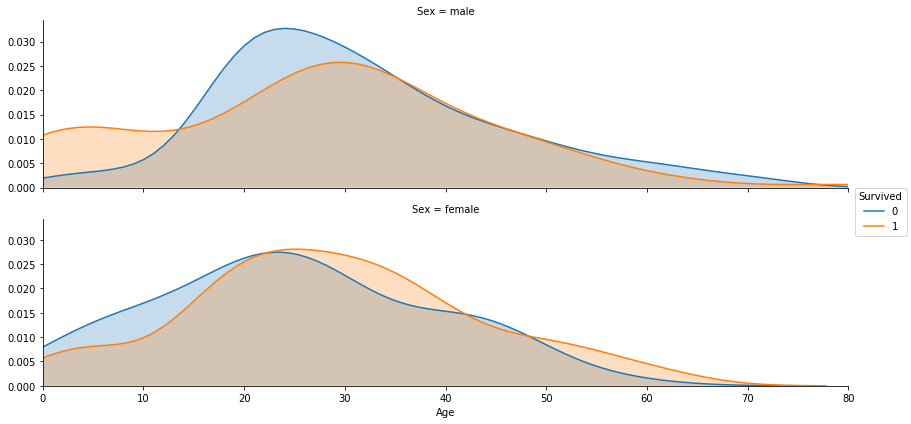

In [9]:
plot_distribution( train , var = 'Age' , target = 'Survived' , row = 'Sex' )

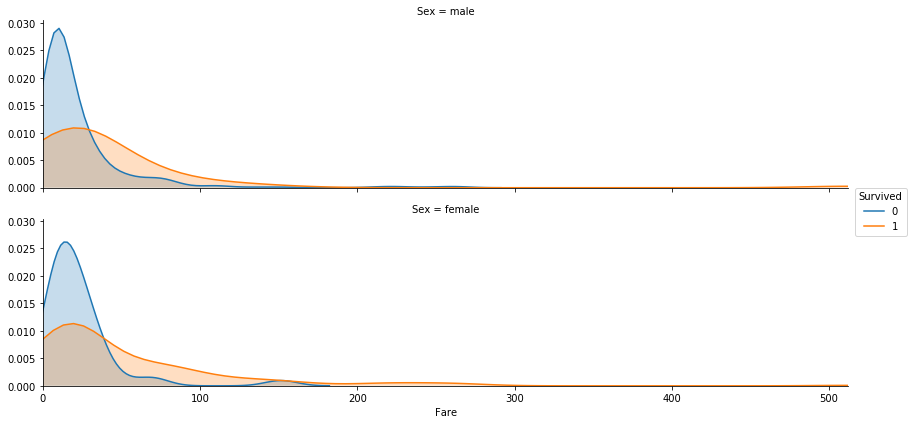

In [10]:
plot_distribution( train , var = 'Fare' , target = 'Survived' , row = 'Sex' )

/hdd/home/superdanby/Github/Kaggle/venv/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


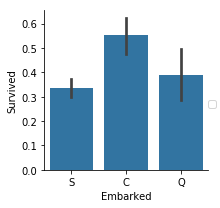

In [11]:
plot_categories( train , cat = 'Embarked' , target = 'Survived' )

/hdd/home/superdanby/Github/Kaggle/venv/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


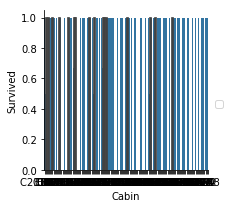

In [12]:
plot_categories( train , cat = 'Cabin' , target = 'Survived' )

/hdd/home/superdanby/Github/Kaggle/venv/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


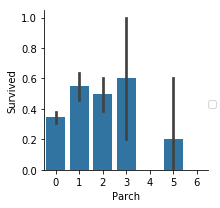

In [13]:
plot_categories( train , cat = 'Parch' , target = 'Survived' )

/hdd/home/superdanby/Github/Kaggle/venv/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


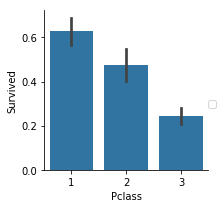

In [14]:
plot_categories( train , cat = 'Pclass' , target = 'Survived' )

/hdd/home/superdanby/Github/Kaggle/venv/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


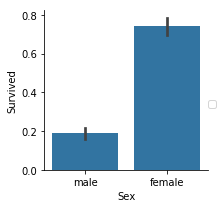

In [15]:
plot_categories( train , cat = 'Sex' , target = 'Survived' )

/hdd/home/superdanby/Github/Kaggle/venv/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


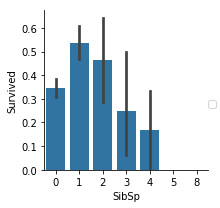

In [16]:
plot_categories( train , cat = 'SibSp' , target = 'Survived' )

In [17]:
# combine test and train
test['Survived'] = -1
whole = train.append(test, ignore_index = True)

In [18]:
# label encoding

In [19]:
le = LabelEncoder()

# dropped = whole.drop(['Name', 'Ticket', 'PassengerId'], axis = 1).iloc[:,:]
dropped = whole.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis = 1).iloc[:,:]

# dropped['Cabin'] = le.fit_transform(dropped['Cabin'].astype(str))

dropped['Embarked'] = le.fit_transform(dropped['Embarked'].astype(str))

dropped['Sex'] = le.fit_transform(dropped['Sex'].astype(str))

In [20]:
# NAN

# Fill missing values of Age with the average of Age (mean)
dropped[ 'Age' ] = dropped.Age.fillna( dropped.Age.mean() )

# Fill missing values of Fare with the average of Fare (mean)
dropped[ 'Fare' ] = dropped.Fare.fillna( dropped.Fare.mean() )

# Fill missing values of Parch with the average of Parch (mean)
dropped[ 'Parch' ] = dropped.Parch.fillna( dropped.Parch.mean() )

# Fill missing values of SibSp with the average of SibSp (mean)
dropped[ 'SibSp' ] = dropped.SibSp.fillna( dropped.SibSp.mean() )

In [21]:
# separate train data and test data
trle = dropped[dropped['Survived'] != -1]

trle_X = trle.drop(['Survived'], axis = 1)

trle_Y = trle.Survived

tsle = dropped[dropped['Survived'] == -1].drop(['Survived'], axis = 1)

0.967452300786


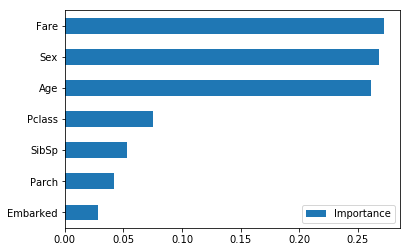

In [22]:
# feature importance
plot_variable_importance(trle_X, trle_Y)

In [23]:
# RandomForest
param_grid = [{'n_estimators': [10, 50, 100], 'class_weight': [{0:1, 1:1}, 'balanced']},
             ]
RF = GridSearchCV(RandomForestClassifier(), param_grid, verbose = 0, n_jobs = -1, scoring = 'accuracy', cv = StratifiedKFold(5), return_train_score = True)

RF.fit(trle_X, trle_Y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [10, 50, 100], 'class_weight': [{0: 1, 1: 1}, 'balanced']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [24]:
print('Best Param:', RF.best_params_)

print('Best Model Score:', RF.best_estimator_.score(trle_X, trle_Y))

display(pd.DataFrame(RF.cv_results_))

Best Param: {'class_weight': {0: 1, 1: 1}, 'n_estimators': 100}
Best Model Score: 0.982042648709


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_class_weight,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.015140,0.001511,0.810325,0.967739,"{0: 1, 1: 1}",10,"{'class_weight': {0: 1, 1: 1}, 'n_estimators':...",3,0.793296,0.973315,...,0.848315,0.966339,0.792135,0.967742,0.841808,0.957983,0.001561,0.000061,0.028964,0.005645
1,0.067461,0.004365,0.808081,0.984009,"{0: 1, 1: 1}",50,"{'class_weight': {0: 1, 1: 1}, 'n_estimators':...",5,0.793296,0.984551,...,0.848315,0.984572,0.780899,0.983170,0.824859,0.980392,0.000706,0.000155,0.024794,0.002264
2,0.112714,0.006533,0.814815,0.984569,"{0: 1, 1: 1}",100,"{'class_weight': {0: 1, 1: 1}, 'n_estimators':...",1,0.787709,0.984551,...,0.842697,0.984572,0.769663,0.984572,0.858757,0.981793,0.021585,0.001229,0.033074,0.001760
3,0.014472,0.001258,0.792368,0.968856,balanced,10,"{'class_weight': 'balanced', 'n_estimators': 10}",6,0.765363,0.964888,...,0.842697,0.969144,0.775281,0.973352,0.813559,0.964986,0.000152,0.000039,0.030767,0.003474
4,0.040834,0.002599,0.809203,0.984569,balanced,50,"{'class_weight': 'balanced', 'n_estimators': 50}",4,0.787709,0.984551,...,0.848315,0.984572,0.780899,0.984572,0.824859,0.981793,0.002079,0.000029,0.024731,0.001760
5,0.078288,0.004848,0.814815,0.984569,balanced,100,"{'class_weight': 'balanced', 'n_estimators': 100}",1,0.793296,0.984551,...,0.853933,0.984572,0.786517,0.984572,0.824859,0.981793,0.000588,0.000032,0.024060,0.001760


In [25]:
# output
tsrf_Y = RF.predict( tsle )

passenger_id = test.PassengerId

tsrf = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': tsrf_Y } )

tsrf.shape

tsrf.head()

tsrf.to_csv( 'RandomForest.csv' , index = False )

In [26]:
# GradientBoosting
param_grid = [{'loss': ['deviance', 'exponential'], 'n_estimators': [10, 100, 200], 'learning_rate': [0.1, 0.5, 0.9]},
             ]
GBC = GridSearchCV(GradientBoostingClassifier(), param_grid, verbose = 0, n_jobs = -1, scoring = 'accuracy', cv = StratifiedKFold(5), return_train_score = True)

GBC.fit(trle_X, trle_Y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'loss': ['deviance', 'exponential'], 'n_estimators': [10, 100, 200], 'learning_rate': [0.1, 0.5, 0.9]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [27]:
print('Best Param:', GBC.best_params_)

print('Best Model Score:', GBC.best_estimator_.score(trle_X, trle_Y))

display(pd.DataFrame(GBC.cv_results_))

Best Param: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 200}
Best Model Score: 0.910213243547


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_loss,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.008627,0.000656,0.817059,0.836137,0.1,deviance,10,"{'learning_rate': 0.1, 'loss': 'deviance', 'n_...",9,0.810056,...,0.820225,0.840112,0.792135,0.842917,0.847458,0.834734,0.000733,1.136103e-04,0.017887,0.004636
1,0.059809,0.000877,0.827160,0.905727,0.1,deviance,100,"{'learning_rate': 0.1, 'loss': 'deviance', 'n_...",2,0.804469,...,0.842697,0.893408,0.808989,0.907433,0.853107,0.906162,0.002474,9.762651e-05,0.018746,0.007570
2,0.113517,0.000908,0.826038,0.932384,0.1,deviance,200,"{'learning_rate': 0.1, 'loss': 'deviance', 'n_...",4,0.810056,...,0.837079,0.927069,0.814607,0.932679,0.841808,0.927171,0.004642,1.410162e-04,0.012300,0.005589
3,0.007944,0.000501,0.811448,0.831934,0.1,exponential,10,"{'learning_rate': 0.1, 'loss': 'exponential', ...",11,0.810056,...,0.814607,0.837307,0.786517,0.840112,0.830508,0.819328,0.000096,6.370487e-05,0.014222,0.007143
4,0.049367,0.000530,0.821549,0.894502,0.1,exponential,100,"{'learning_rate': 0.1, 'loss': 'exponential', ...",6,0.804469,...,0.837079,0.887798,0.797753,0.896213,0.847458,0.894958,0.009087,8.464382e-05,0.018796,0.006709
5,0.083615,0.000708,0.828283,0.925085,0.1,exponential,200,"{'learning_rate': 0.1, 'loss': 'exponential', ...",1,0.804469,...,0.853933,0.917251,0.814607,0.928471,0.836158,0.925770,0.000728,2.132832e-05,0.017276,0.004386
6,0.004666,0.000282,0.827160,0.878507,0.5,deviance,10,"{'learning_rate': 0.5, 'loss': 'deviance', 'n_...",2,0.798883,...,0.865169,0.870968,0.814607,0.886396,0.841808,0.878151,0.000045,9.368364e-07,0.023452,0.004903
7,0.039287,0.000497,0.820426,0.971380,0.5,deviance,100,"{'learning_rate': 0.5, 'loss': 'deviance', 'n_...",7,0.810056,...,0.837079,0.978962,0.808989,0.970547,0.824859,0.969188,0.000260,1.607938e-05,0.010352,0.004223
8,0.083753,0.000732,0.801347,0.982887,0.5,deviance,200,"{'learning_rate': 0.5, 'loss': 'deviance', 'n_...",17,0.793296,...,0.803371,0.981767,0.803371,0.983170,0.802260,0.978992,0.010451,1.234262e-05,0.004097,0.002395
9,0.004879,0.000266,0.806958,0.859988,0.5,exponential,10,"{'learning_rate': 0.5, 'loss': 'exponential', ...",15,0.765363,...,0.820225,0.852735,0.786517,0.868163,0.841808,0.861345,0.000085,4.380678e-06,0.027357,0.005450


In [28]:
# output
tsgbc_Y = GBC.predict( tsle )

passenger_id = test.PassengerId

tsgbc = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': tsgbc_Y } )

tsgbc.shape

tsgbc.head()

tsgbc.to_csv( 'GradientBoost.csv' , index = False )

In [29]:
# LogisticRegression
param_grid = [{'penalty': ['l1'], 'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga'], 'class_weight': [{0:1, 1:1}, 'balanced']},
              {'penalty': ['l2'], 'C': [0.1, 1, 10], 'solver': ['newton-cg', 'sag', 'lbfgs'], 'class_weight': [{0:1, 1:1}, 'balanced']},
             ]
LR = GridSearchCV(LogisticRegression(), param_grid, verbose = 0, n_jobs = -1, scoring = 'accuracy', cv = StratifiedKFold(5), return_train_score = True)

LR.fit(trle_X, trle_Y)

/hdd/home/superdanby/Github/Kaggle/venv/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/hdd/home/superdanby/Github/Kaggle/venv/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/hdd/home/superdanby/Github/Kaggle/venv/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/hdd/home/superdanby/Github/Kaggle/venv/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/hdd/home/superdanby/Github/Kaggle/venv/lib/python3.

/hdd/home/superdanby/Github/Kaggle/venv/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/hdd/home/superdanby/Github/Kaggle/venv/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/hdd/home/superdanby/Github/Kaggle/venv/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/hdd/home/superdanby/Github/Kaggle/venv/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/hdd/home/superdanby/Github/Kaggle/venv/lib/python3.

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'penalty': ['l1'], 'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga'], 'class_weight': [{0: 1, 1: 1}, 'balanced']}, {'penalty': ['l2'], 'C': [0.1, 1, 10], 'solver': ['newton-cg', 'sag', 'lbfgs'], 'class_weight': [{0: 1, 1: 1}, 'balanced']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [30]:
print('Best Param:', LR.best_params_)

print('Best Model Score:', LR.best_estimator_.score(trle_X, trle_Y))

display(pd.DataFrame(LR.cv_results_))

Best Param: {'C': 0.1, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l1', 'solver': 'liblinear'}
Best Model Score: 0.792368125701


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_class_weight,param_penalty,param_solver,params,rank_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.004839,0.000484,0.794613,0.791249,0.1,"{0: 1, 1: 1}",l1,liblinear,"{'C': 0.1, 'class_weight': {0: 1, 1: 1}, 'pena...",1,...,0.786517,0.796634,0.764045,0.793829,0.807910,0.781513,0.000521,0.000081,0.017387,0.005138
1,0.021139,0.000424,0.691358,0.690801,0.1,"{0: 1, 1: 1}",l1,saga,"{'C': 0.1, 'class_weight': {0: 1, 1: 1}, 'pena...",24,...,0.679775,0.705470,0.691011,0.687237,0.706215,0.677871,0.003696,0.000112,0.031265,0.016399
2,0.004097,0.000411,0.780022,0.781985,0.1,balanced,l1,liblinear,"{'C': 0.1, 'class_weight': 'balanced', 'penalt...",12,...,0.775281,0.784011,0.752809,0.792426,0.796610,0.778711,0.000569,0.000029,0.023331,0.005916
3,0.018132,0.000366,0.690236,0.691645,0.1,balanced,l1,saga,"{'C': 0.1, 'class_weight': 'balanced', 'penalt...",25,...,0.702247,0.687237,0.730337,0.685835,0.717514,0.684874,0.003424,0.000047,0.058369,0.011648
4,0.003667,0.000255,0.786756,0.803312,1,"{0: 1, 1: 1}",l1,liblinear,"{'C': 1, 'class_weight': {0: 1, 1: 1}, 'penalt...",2,...,0.780899,0.802244,0.764045,0.806452,0.824859,0.799720,0.000169,0.000023,0.020172,0.003153
5,0.013572,0.000293,0.690236,0.689118,1,"{0: 1, 1: 1}",l1,saga,"{'C': 1, 'class_weight': {0: 1, 1: 1}, 'penalt...",25,...,0.674157,0.702665,0.685393,0.684432,0.711864,0.676471,0.000265,0.000008,0.032486,0.015138
6,0.003973,0.000249,0.778900,0.789845,1,balanced,l1,liblinear,"{'C': 1, 'class_weight': 'balanced', 'penalty'...",13,...,0.780899,0.786816,0.764045,0.795231,0.796610,0.784314,0.000184,0.000020,0.010461,0.003868
7,0.018356,0.000398,0.694725,0.696134,1,balanced,l1,saga,"{'C': 1, 'class_weight': 'balanced', 'penalty'...",19,...,0.707865,0.694250,0.747191,0.687237,0.723164,0.690476,0.003844,0.000013,0.063863,0.011703
8,0.004004,0.000258,0.784512,0.802752,10,"{0: 1, 1: 1}",l1,liblinear,"{'C': 10, 'class_weight': {0: 1, 1: 1}, 'penal...",9,...,0.780899,0.805049,0.764045,0.802244,0.813559,0.798319,0.000389,0.000034,0.016393,0.003266
9,0.015304,0.000328,0.690236,0.689679,10,"{0: 1, 1: 1}",l1,saga,"{'C': 10, 'class_weight': {0: 1, 1: 1}, 'penal...",25,...,0.679775,0.702665,0.685393,0.683029,0.711864,0.679272,0.003129,0.000047,0.033750,0.015224


In [31]:
# output
tsLR_Y = LR.predict( tsle )

passenger_id = test.PassengerId

tsLR = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': tsLR_Y } )

tsLR.shape

tsLR.head()

tsLR.to_csv( 'LogisticRegression.csv' , index = False )

In [32]:
# one hot encoding

In [33]:
# get numerical features
numerical = pd.DataFrame()

# Fill missing values of Age with the average of Age (mean)
numerical[ 'Age' ] = whole.Age.fillna( whole.Age.mean() )

# Fill missing values of Fare with the average of Fare (mean)
numerical[ 'Fare' ] = whole.Fare.fillna( whole.Fare.mean() )

# Fill missing values of Parch with the average of Parch (mean)
numerical[ 'Parch' ] = whole.Parch.fillna( whole.Parch.mean() )

# Fill missing values of SibSp with the average of SibSp (mean)
numerical[ 'SibSp' ] = whole.SibSp.fillna( whole.SibSp.mean() )

numerical.head()

,Age,Fare,Parch,SibSp
0,22.0,7.2500,0,1
1,38.0,71.2833,0,1
2,26.0,7.9250,0,0
3,35.0,53.1000,0,1
4,35.0,8.0500,0,0


In [34]:
# get categorial features
cabin = pd.DataFrame()

# replacing missing cabins with U (for Uknown)
cabin[ 'Cabin' ] = whole.Cabin.fillna( 'Unknown' )

# dummy encoding ...
cabin = pd.get_dummies( cabin['Cabin'] , prefix = 'Cabin' )

cabin.head()

,Cabin_A10,Cabin_A11,Cabin_A14,Cabin_A16,Cabin_A18,Cabin_A19,Cabin_A20,Cabin_A21,Cabin_A23,Cabin_A24,...,Cabin_F E69,Cabin_F G63,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Cabin_Unknown
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [35]:
# get categorial features
embarked = pd.DataFrame()

# replacing missing cabins with U (for Uknown)
embarked[ 'Embarked' ] = whole.Embarked.fillna( 'Unknown' )

# dummy encoding ...
embarked = pd.get_dummies( embarked['Embarked'] , prefix = 'Embarked' )

embarked.head()

,Embarked_C,Embarked_Q,Embarked_S,Embarked_Unknown
0,0,0,1,0
1,1,0,0,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


In [36]:
# get categorial features
pclass = pd.DataFrame()

# replacing missing cabins with U (for Uknown)
pclass[ 'Pclass' ] = whole.Pclass.fillna( 'Unknown' )

# dummy encoding ...
pclass = pd.get_dummies( pclass['Pclass'] , prefix = 'Pclass' )

pclass.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


In [37]:
# get categorial features
sex = pd.DataFrame()

# replacing missing cabins with U (for Uknown)
sex[ 'Sex' ] = whole.Sex.fillna( 'Unknown' )

# dummy encoding ...
sex = pd.get_dummies( sex['Sex'] , prefix = 'Sex' )

sex.head()

,Sex_female,Sex_male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1


In [38]:
# combine all features
ready = pd.concat([numerical, cabin, pclass, sex, whole.Survived], axis = 1)

ready.head()

,Age,Fare,Parch,SibSp,Cabin_A10,Cabin_A11,Cabin_A14,Cabin_A16,Cabin_A18,Cabin_A19,...,Cabin_F4,Cabin_G6,Cabin_T,Cabin_Unknown,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Survived
0,22.0,7.2500,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
1,38.0,71.2833,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
2,26.0,7.9250,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,1
3,35.0,53.1000,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
4,35.0,8.0500,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0


In [39]:
# separate train data and test data
trohe = ready[ready['Survived'] != -1]

trohe_X = trohe.drop(['Survived'], axis = 1)

trohe_Y = trohe.Survived

tsohe = ready[ready['Survived'] == -1].drop(['Survived'], axis = 1)

In [40]:
# standardize
sc = StandardScaler()

sc.fit(trohe_X)

trstd_X = sc.transform(trohe_X)

tsstd = sc.transform(tsohe)

In [41]:
# PCA
pca = PCA(n_components = 0.95)

trpca_X = pca.fit_transform(trstd_X)

tspca = pca.transform(tsstd)

pca.explained_variance_ratio_

array([ 0.02328329,  0.01583371,  0.01158622,  0.00983334,  0.0083634 ,
        0.00803865,  0.00721866,  0.00684796,  0.00639709,  0.00639266,
        0.00639178,  0.00639094,  0.00639093,  0.00639014,  0.00638747,
        0.00638459,  0.00638376,  0.00638376,  0.00638376,  0.00638376,
        0.00638376,  0.00638376,  0.00638376,  0.00638376,  0.00638376,
        0.00638376,  0.00638376,  0.00638376,  0.00638376,  0.00638376,
        0.00638376,  0.00638376,  0.00638376,  0.00638376,  0.00638376,
        0.00638376,  0.00638376,  0.00638376,  0.00638376,  0.00638376,
        0.00638376,  0.00638376,  0.00638376,  0.00638376,  0.00638376,
        0.00638376,  0.00638236,  0.00638215,  0.00638139,  0.00638067,
        0.00638033,  0.00637967,  0.00637867,  0.00637782,  0.00637658,
        0.00637658,  0.00637658,  0.00637658,  0.00637658,  0.00637658,
        0.00637658,  0.00637658,  0.00637658,  0.00637658,  0.00637658,
        0.00637658,  0.00637658,  0.00637658,  0.00637658,  0.00

In [42]:
cov_mat = np.cov(trstd_X.T)

eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[  3.65958401e+00   2.48868588e+00   1.82107991e+00   1.54556867e+00
   1.20120770e-01   2.05148278e-01   3.76339613e-01   4.57377897e-01
   1.31452874e+00   6.80901036e-01   1.26348610e+00   7.93501504e-01
   8.70258505e-01   1.13460346e+00   1.07633704e+00  -1.53652359e-15
   2.87021781e-16  -1.50181553e-16   1.00547180e+00   1.00477483e+00
   1.00463734e+00   1.00395931e+00   1.00437908e+00   1.00450295e+00
   1.00450570e+00   1.00350660e+00   1.00244331e+00   1.00315648e+00
   1.00312270e+00   1.00300417e+00   1.00273391e+00   1.00257593e+00
   1.00283670e+00   1.00289087e+00   1.00224845e+00   1.00224845e+00
   1.00337584e+00   1.00337584e+00   1.00224845e+00   1.00337584e+00
   1.00337584e+00   1.00337584e+00   1.00337584e+00   1.00337584e+00
   1.00337584e+00   1.00224845e+00   1.00224845e+00   1.00224845e+00
   1.00224845e+00   1.00224845e+00   1.00224845e+00   1.00224845e+00
   1.00224845e+00   1.00337584e+00   1.00337584e+00   1.00337584e+00
   1.00337584e+00   

In [43]:
# LDA
# lda = LinearDiscriminantAnalysis(n_components=10)

# trlda_X = lda.fit_transform(trstd_X, trohe_Y)

# tslda = lda.transform(tsstd)

# lda.explained_variance_ratio_

In [44]:
# SVM
param_grid = [
   {'C': [0.1, 1, 10], 'gamma': ['auto', (1 / 10), 1, 10], 'kernel': ['rbf'], 'class_weight': [{0:1, 1:1}, 'balanced']},
   {'C': [ 0.1, 1, 10], 'kernel': ['poly'], 'class_weight': [{0:1, 1:1}, 'balanced']},
   {'C': [ 0.1, 1, 10], 'kernel': ['sigmoid'], 'class_weight': [{0:1, 1:1}, 'balanced']},
 ]

SVM = GridSearchCV(SVC(), param_grid, verbose = 0, n_jobs = -1, scoring = 'accuracy', cv = StratifiedKFold(5), return_train_score = True)

SVM.fit(trpca_X, trohe_Y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'C': [0.1, 1, 10], 'gamma': ['auto', 0.1, 1, 10], 'kernel': ['rbf'], 'class_weight': [{0: 1, 1: 1}, 'balanced']}, {'C': [0.1, 1, 10], 'kernel': ['poly'], 'class_weight': [{0: 1, 1: 1}, 'balanced']}, {'C': [0.1, 1, 10], 'kernel': ['sigmoid'], 'class_weight': [{0: 1, 1: 1}, 'balanced']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [45]:
print('Best Param:', SVM.best_params_)

print('Best Model Score:', SVM.best_estimator_.score(trpca_X, trohe_Y))

display(pd.DataFrame(SVM.cv_results_))

Best Param: {'C': 10, 'class_weight': {0: 1, 1: 1}, 'gamma': 1, 'kernel': 'rbf'}
Best Model Score: 0.897867564534


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_class_weight,param_gamma,param_kernel,params,rank_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.067622,0.015151,0.692480,0.693609,0.1,"{0: 1, 1: 1}",auto,rbf,"{'C': 0.1, 'class_weight': {0: 1, 1: 1}, 'gamm...",28,...,0.674157,0.698457,0.724719,0.685835,0.734463,0.683473,0.001077,0.000150,0.030743,0.007495
1,0.063431,0.013673,0.774411,0.780875,0.1,"{0: 1, 1: 1}",0.1,rbf,"{'C': 0.1, 'class_weight': {0: 1, 1: 1}, 'gamm...",10,...,0.769663,0.776999,0.775281,0.772791,0.790960,0.767507,0.000647,0.000042,0.010149,0.010915
2,0.067269,0.015051,0.773288,0.809177,0.1,"{0: 1, 1: 1}",1,rbf,"{'C': 0.1, 'class_weight': {0: 1, 1: 1}, 'gamm...",11,...,0.792135,0.809257,0.764045,0.786816,0.830508,0.866947,0.001039,0.000093,0.034364,0.030829
3,0.070405,0.016087,0.618406,0.633839,0.1,"{0: 1, 1: 1}",10,rbf,"{'C': 0.1, 'class_weight': {0: 1, 1: 1}, 'gamm...",36,...,0.606742,0.633941,0.623596,0.633941,0.621469,0.633053,0.001131,0.000096,0.005966,0.003135
4,0.077512,0.017281,0.760943,0.760663,0.1,balanced,auto,rbf,"{'C': 0.1, 'class_weight': 'balanced', 'gamma'...",19,...,0.803371,0.747546,0.769663,0.767181,0.785311,0.763305,0.001143,0.000176,0.033698,0.008099
5,0.067628,0.014051,0.766554,0.767680,0.1,balanced,0.1,rbf,"{'C': 0.1, 'class_weight': 'balanced', 'gamma'...",15,...,0.769663,0.767181,0.764045,0.767181,0.785311,0.761905,0.001185,0.000086,0.010631,0.003810
6,0.072611,0.015498,0.710438,0.715216,0.1,balanced,1,rbf,"{'C': 0.1, 'class_weight': 'balanced', 'gamma'...",26,...,0.735955,0.715288,0.724719,0.708275,0.757062,0.704482,0.001013,0.000241,0.036990,0.008282
7,0.078002,0.017635,0.628507,0.640301,0.1,balanced,10,rbf,"{'C': 0.1, 'class_weight': 'balanced', 'gamma'...",35,...,0.651685,0.628331,0.634831,0.638149,0.672316,0.631653,0.000774,0.000207,0.032240,0.010441
8,0.057563,0.012334,0.760943,0.829128,1,"{0: 1, 1: 1}",auto,rbf,"{'C': 1, 'class_weight': {0: 1, 1: 1}, 'gamma'...",19,...,0.758427,0.824684,0.758427,0.833100,0.785311,0.823529,0.001341,0.000115,0.013613,0.004154
9,0.056031,0.011530,0.787879,0.865324,1,"{0: 1, 1: 1}",0.1,rbf,"{'C': 1, 'class_weight': {0: 1, 1: 1}, 'gamma'...",8,...,0.780899,0.866760,0.808989,0.863955,0.813559,0.858543,0.001701,0.000208,0.019728,0.004033


In [46]:
# output
tssvm_Y = SVM.predict( tspca )

passenger_id = test.PassengerId

tssvm = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': tssvm_Y } )

tssvm.shape

tssvm.head()

tssvm.to_csv( 'SVM.csv' , index = False )

In [47]:
# KNN
param_grid = [{'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'leaf_size': [10, 30, 50]},]
KNN = GridSearchCV(KNeighborsClassifier(), param_grid, verbose = 0, n_jobs = -1, scoring = 'accuracy', cv = StratifiedKFold(5), return_train_score = True)

KNN.fit(trpca_X, trohe_Y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'leaf_size': [10, 30, 50]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [48]:
print('Best Param:', KNN.best_params_)

print('Best Model Score:', KNN.best_estimator_.score(trpca_X, trohe_Y))

display(pd.DataFrame(KNN.cv_results_))

Best Param: {'algorithm': 'kd_tree', 'leaf_size': 30, 'n_neighbors': 5, 'weights': 'uniform'}
Best Model Score: 0.859708193042


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_algorithm,param_leaf_size,param_n_neighbors,param_weights,params,rank_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.005140,0.022062,0.801347,0.879357,ball_tree,10,3,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 10, 'n...",21,...,0.820225,0.870968,0.775281,0.886396,0.864407,0.865546,0.000921,0.001082,0.038166,0.009237
1,0.005068,0.022165,0.790123,0.991021,ball_tree,10,3,distance,"{'algorithm': 'ball_tree', 'leaf_size': 10, 'n...",39,...,0.837079,0.991585,0.758427,0.991585,0.836158,0.990196,0.000807,0.000794,0.037844,0.002281
2,0.004310,0.021905,0.803591,0.856072,ball_tree,10,5,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 10, 'n...",5,...,0.820225,0.845722,0.808989,0.854137,0.824859,0.841737,0.000330,0.000703,0.019654,0.011582
3,0.004046,0.021841,0.789001,0.991021,ball_tree,10,5,distance,"{'algorithm': 'ball_tree', 'leaf_size': 10, 'n...",44,...,0.825843,0.991585,0.764045,0.991585,0.836158,0.990196,0.000112,0.000744,0.034540,0.002281
4,0.004148,0.022011,0.803591,0.830816,ball_tree,10,7,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 10, 'n...",5,...,0.825843,0.821879,0.803371,0.833100,0.796610,0.819328,0.000247,0.000558,0.011591,0.008782
5,0.004125,0.021968,0.794613,0.991021,ball_tree,10,7,distance,"{'algorithm': 'ball_tree', 'leaf_size': 10, 'n...",28,...,0.831461,0.991585,0.780899,0.991585,0.819209,0.990196,0.000126,0.000685,0.025573,0.002281
6,0.003257,0.021114,0.802469,0.879638,ball_tree,30,3,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n...",19,...,0.820225,0.872370,0.775281,0.886396,0.870056,0.864146,0.000049,0.000393,0.040041,0.009701
7,0.003366,0.021569,0.791246,0.991021,ball_tree,30,3,distance,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n...",37,...,0.837079,0.991585,0.758427,0.991585,0.841808,0.990196,0.000137,0.000464,0.039250,0.002281
8,0.003495,0.021299,0.803591,0.856072,ball_tree,30,5,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n...",5,...,0.820225,0.845722,0.808989,0.854137,0.824859,0.841737,0.000238,0.000459,0.019654,0.011582
9,0.003189,0.021142,0.787879,0.991021,ball_tree,30,5,distance,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n...",51,...,0.825843,0.991585,0.764045,0.991585,0.830508,0.990196,0.000056,0.000421,0.033050,0.002281


In [49]:
# output
tsknn_Y = KNN.predict( tspca )

passenger_id = test.PassengerId

tsknn = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': tsknn_Y } )

tsknn.shape

tsknn.head()

tsknn.to_csv( 'kNearistNeighbor.csv' , index = False )